# read and extract data

In [ ]:
DATASET_PATH = "1mWY8_dins5txSqKR0NlOiBnwh7kc5zNA"

In [ ]:
!gdown -q $DATASET_PATH -O trainval.zip
!unzip -q trainval.zip

# install

In [ ]:
%%capture
%pip install scikit-fuzzy

# imports

In [ ]:
from PIL import Image
import os
import io
import re
import csv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score



import cv2 as cv

from skfuzzy import cmeans
from scipy.spatial.distance import cdist

# Jaccard

In [ ]:
def jaccard_similarity(image1, image2):
    """
    Calculate the Jaccard similarity score between two images.

    Args:
    image1 (PIL.Image): The first image.
    image2 (PIL.Image): The second image.

    Returns:
    float: The Jaccard similarity score.
    """
    # Flatten binary arrays
    flattened_binary_array1 = image1
    flattened_binary_array2 = image2

    # Calculate Jaccard similarity score
    score = jaccard_score(flattened_binary_array1, flattened_binary_array2, average="micro", zero_division=1)

    return score

# show images

In [ ]:
def show_images(images, titles=None):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(10*num_images, 5))

    for i in range(num_images):
        ax = axes[i] if num_images > 1 else axes  # Handle single image case
        ax.imshow(images[i])
        ax.axis('off')  # Hide axis for the image
        if titles:
            ax.set_title(titles[i])  # Set title if titles are provided

    plt.show()

# sort and get images

In [ ]:
def sorted_alphanumeric(data):
    def convert(text): return int(text) if text.isdigit() else text.lower()

    def alphanum_key(key): return [convert(c) for c in re.split('([0-9]+)', key)]

    return sorted(data, key=alphanum_key)


def read_images(folder_path):
  files = os.listdir(folder_path)
  files = sorted_alphanumeric(files)
  images = []

  for idx, file in enumerate(files):
      image = Image.open(os.path.join(folder_path, file))
      images.append(image)
  return images

In [ ]:
A = read_images('/content/trainval/A')
B = read_images('/content/trainval/B')
label = read_images('/content/trainval/label')

# image difference

In [ ]:
class image_difference():

  def __init__(self):
      self.jaccard_scores = []
      self.all_ground_truth = []
      self.all_bcm = []


  def otsu(self, data, num=400):
    mx = np.max(data)
    mn = np.min(data)

    total = data.size
    step = (mx - mn) / num
    val = mn + step
    best_1 = mn
    best_2 = 0
    while val <= mx:
        data_1 = data[data <= val]
        data_2 = data[data > val]
        if data_1.size == 0 or data_2.size == 0:
            val += step
            continue
        w1 = data_1.size / total
        w2 = data_2.size / total

        mean_1 = data_1.mean()
        mean_2 = data_2.mean()

        ICV = w1 * w2 * np.power((mean_1 - mean_2), 2)
        if best_2 < ICV:
            best_2 = ICV
            best_1 = val
        val += step

    return best_1

  def get_difference(self, img_X, img_Y):
      img_diff = img_X - img_Y
      return img_diff

  def run(self, A, B, label):

    for idx in range(len(A)):
        if idx % 100 == 0: print(idx)
        # show_images([A[idx], B[idx]])

        img1  = A[idx].convert('L')
        img2  = B[idx].convert('L')

        data_set_X = np.array(img1)
        data_set_Y = np.array(img2)
        ground_truth = np.array(label[idx]) / 255

        img_height, img_width = data_set_X.shape[:2]

        img_diff = self.get_difference(data_set_X, data_set_Y)

        bcm = np.zeros((img_height, img_width))
        thre = self.otsu(img_diff.reshape(1, -1))


        bcm[img_diff > thre] = 1
        self.all_ground_truth.extend(ground_truth.flatten())
        self.all_bcm.extend(bcm.flatten())

        # print(ground_truth, bcm)
        self.jaccard_scores.append(jaccard_similarity(ground_truth.flatten(), bcm.flatten()))


  def calculate_metrics(self):
    print(f'the Jaccard accuracy = {np.array(self.jaccard_scores).mean()*100}')

    confusion_mat = confusion_matrix(self.all_ground_truth, self.all_bcm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(self.all_ground_truth, self.all_bcm)
    precision = precision_score(self.all_ground_truth, self.all_bcm)
    f1 = f1_score(self.all_ground_truth, self.all_bcm)
    recall = recall_score(self.all_ground_truth, self.all_bcm)

    print(f'Accuracy: {accuracy * 100:.2f}%\nPrecision: {precision * 100:.2f}%\nF1 Score: {f1 * 100:.2f}%\nRecall: {recall * 100:.2f}%')

In [ ]:
import numpy as np

random_indices = np.random.randint(0, 4000, size=500)

In [ ]:
A_test = [A[i] for i in random_indices]
B_test = [B[i] for i in random_indices]
label_test = [label[i] for i in random_indices]

In [ ]:
img_diff_model = image_difference()
img_diff_model.run(A_test, B_test, label_test)

0
100
200
300
400


the Jaccard accuracy = 31.04336820803229


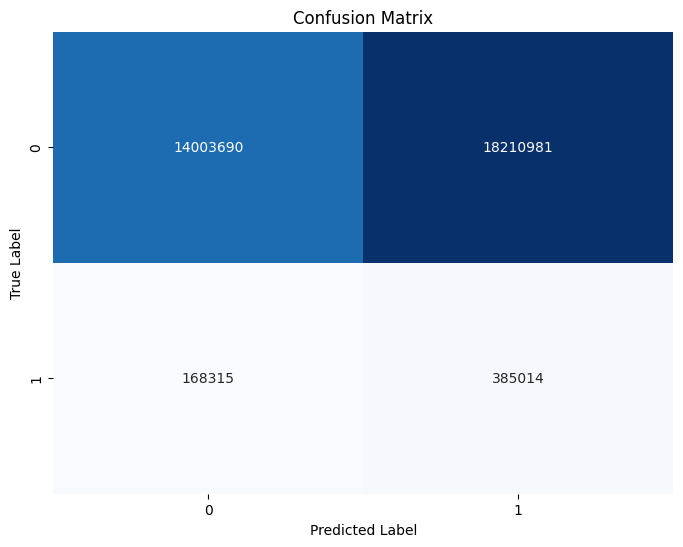

Accuracy: 43.91%
Precision: 2.07%
F1 Score: 4.02%
Recall: 69.58%


In [ ]:
img_diff_model.calculate_metrics()

# CVA

In [ ]:
class CVA():

  def __init__(self):
      self.jaccard_scores = []
      self.all_ground_truth = []
      self.all_bcm = []


  def otsu(self, data, num=400):
    mx = np.max(data)
    mn = np.min(data)

    total = data.size
    step = (mx - mn) / num
    val = mn + step
    best_1 = mn
    best_2 = 0
    while val <= mx:
        data_1 = data[data <= val]
        data_2 = data[data > val]
        if data_1.size == 0 or data_2.size == 0:
            val += step
            continue
        w1 = data_1.size / total
        w2 = data_2.size / total

        mean_1 = data_1.mean()
        mean_2 = data_2.mean()

        ICV = w1 * w2 * np.power((mean_1 - mean_2), 2)
        if best_2 < ICV:
            best_2 = ICV
            best_1 = val
        val += step

    return best_1


  def CVA_calc(self, img_X, img_Y):
    img_diff = img_X - img_Y
    L2_norm = np.sqrt(np.sum(np.square(img_diff), axis=2))
    return L2_norm

  def run(self, A, B, label):
    for idx in range(len(A_test)):
      if idx % 100 == 0: print(idx)

      data_set_X = np.array(A_test[idx])
      data_set_Y = np.array(B_test[idx])
      ground_truth = np.array(label_test[idx])/255
      # show_images([data_set_X, data_set_Y])

      img_height, img_width = data_set_X.shape[:2]

      L2_norm = self.CVA_calc(data_set_X, data_set_Y)

      bcm = np.zeros((img_height, img_width))
      thre = self.otsu(L2_norm.reshape(1, -1))

      bcm[L2_norm > thre] = 1

      bcm = bcm.astype(np.uint8)
      # show_images([bcm, ground_truth])

      self.all_ground_truth.extend(ground_truth.flatten())
      self.all_bcm.extend(bcm.flatten())

      self.jaccard_scores.append(jaccard_similarity(ground_truth.flatten(), bcm.flatten()))



  def calculate_metrics(self):
    print(f'the Jaccard accuracy = {np.array(self.jaccard_scores).mean()*100}')

    accuracy = accuracy_score(self.all_ground_truth, self.all_bcm)
    precision = precision_score(self.all_ground_truth, self.all_bcm)
    f1 = f1_score(self.all_ground_truth, self.all_bcm)
    recall = recall_score(self.all_ground_truth, self.all_bcm)

    print(f'Accuracy: {accuracy * 100:.2f}%\nPrecision: {precision * 100:.2f}%\nF1 Score: {f1 * 100:.2f}%\nRecall: {recall * 100:.2f}%')

    confusion_mat = confusion_matrix(self.all_ground_truth, self.all_bcm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

0
100
200
300
400
the Jaccard accuracy = 24.684784855737227
Accuracy: 39.53%
Precision: 1.80%
F1 Score: 3.50%
Recall: 64.95%


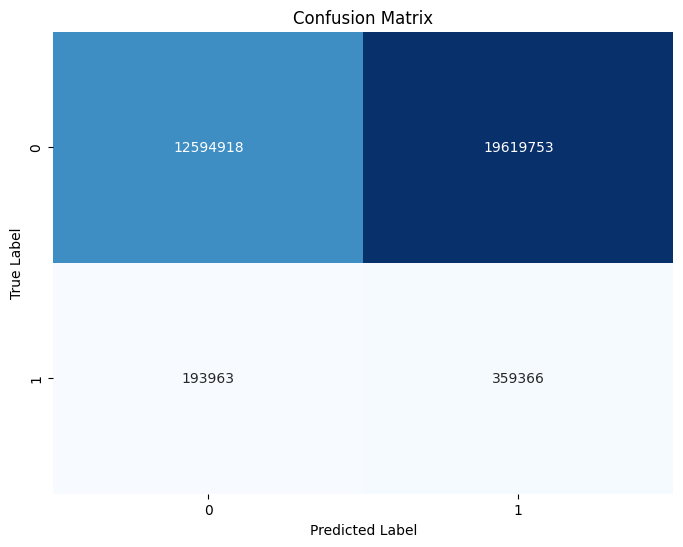

In [ ]:
img_diff_model = CVA()
img_diff_model.run(A_test, B_test, label_test)
img_diff_model.calculate_metrics()